# Targeted Maximum Likelihood Estimator
The targeted maximum likelihood estimator (TMLE) is a doubly robust estimator. What distinguishes it from other doubly robust estimators (augmented-IPTW) is that it uses a secondary targeting (hence the name) step that optimizes the bias-variance tradeoff for the target parameter. A common target parameter is the sample average treatment effect, which compares to counterfactual where all individuals in the study sample were treated versus the counterfactual where no individual was treated. Throughout this section, I will use the notation that is common in the TMLE literature. This is a little different from the notation in other documents.

The target parameter is defined as
$$\psi = E_L\left[E\left[Y^{a=1}|L\right] - E\left[Y^{a=0}|L\right]\right]$$
We will focus on this parameter, but other estimates (like risk ratio and odds ratio) are also implemented

This tutorial provides a basic introduction to fitting TMLE using *zEpid*. Additionally, I demonstrate how to use machine learning algorithms / super learner to estimate `TMLE` with less restrictive functional form assumptions

## Doubly Robust Estimators
Before continuing, I will briefly outline what a doubly-robust estimator is and why you would want to use one. In observational research with high-dimensional data, we (generally) are forced to use parametric models to adjust for many confounders. In this scenario, we assume that our parametric models are correctly specified. Our statistical model, $\mathcal{M}$, must include the distribution that the data came from. 

With other estimators, like IPTW or g-formula, we have one chance to specify $\mathcal{M}$ correctly. Doubly-robust estimators use a model to predict the treatment (like IPTW) and another model to predict the outcome (like g-formula). The estimator then combines the estimates, such that if either is correct, then our estimate will be consistent. Essentially, we get two chances to get the statistical model correct.

A more in-depth description of doubly robust estimators is available in [this pre-print](https://statnav.files.wordpress.com/2017/10/doublerobustness-preprint.pdf)

## TMLE Procedure
I will briefly outline how TMLE (complete-case) is estimated.

1) Initial estimates for $Y$ are predicted from a statistical model. Predicted values of $Y$ are generated for each treatment $Y^{a=1}$ and $Y^{a=0}$. This is commonly refered to as $Q_0$
$$E\left[Y | A, L\right]$$

2) Predicted probabilities of treatment are estimated from a second statistical model. 
$$\Pr(A=1|L)$$

3) Using the predicted probabilities from step 2, we calculate what is referred to as the "clever covariate". Clever covariates are calculated for each individual using the following formula
$$ H(A=a,L) = \frac{I(A=1)}{\pi_1} - \frac{I(A=0)}{\pi_0}$$

4) Calculate the updated counterfactual outcomes $Q_n$ through the targeting step. For a single targeting step, we fit the following logistic regression model
$$logit\left(E(Y|A,L)\right) = logit(\hat{Y}^a) + \sigma * H$$
where the predicted outcome is an offset. 

5) From the targeting step, we predict the targeted estimate via
$$\hat{Y}_*^1 = logit(\hat{Y}^1) + \sigma * H(A=1,L)$$
$$\hat{Y}_*^0 = logit(\hat{Y}^0) + \sigma * H(A=0,L)$$
then from the predicted individual outcomes, we generate the target parameter using
$$\psi = \frac{1}{n} \sum_{i=1}^n \left(\hat{Y}_*^1 - \hat{Y}_*^0\right)$$

For a more indepth discussion, please refer to [Schuler and Rose 2017](https://academic.oup.com/aje/article/185/1/65/2662306)

## An example
To motivate our example, we will use a simulated data set included with *zEpid*. In the data set, we have a cohort of HIV-positive individuals. We are interested in the sample average treatment effect of antiretroviral therapy (ART) on all-cause mortality at 45-weeks. Based on substantive background knowledge, we believe that the treated and untreated population are exchangeable based gender, age, CD4 T-cell count, and detectable viral load. 

In this tutorial, we will focus on a complete case analysis. Therefore, we will drop the `cd4_wk45` column and all the missing data in `dead`. This will leave 517 observations with no missing data

In [1]:
from zepid import load_sample_data, spline
from zepid.causal.doublyrobust import TMLE

df = load_sample_data(False)
df[['age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=3, term=2, restricted=True)
df[['cd4_rs1', 'cd4_rs2']] = spline(df, 'cd40', n_knots=3, term=2, restricted=True)

dfcc = df.drop(columns=['cd4_wk45']).dropna()
dfcc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 0 to 546
Data columns (total 12 columns):
id         517 non-null int64
male       517 non-null int64
age0       517 non-null int64
cd40       517 non-null int64
dvl0       517 non-null int64
art        517 non-null int64
dead       517 non-null float64
t          517 non-null float64
age_rs1    517 non-null float64
age_rs2    517 non-null float64
cd4_rs1    517 non-null float64
cd4_rs2    517 non-null float64
dtypes: float64(6), int64(6)
memory usage: 52.5 KB


Our data is now ready to conduct a complete case analysis using TMLE. First, we initialize TMLE with our complete-case data (`dfcc`), the treatment (`art`), and the outcome (`dead`)

In [2]:
tml = TMLE(dfcc, exposure='art', outcome='dead')

### Treatment Model
As the first step, we will estimate the treatment model. We believe the sufficient set for the treatment model is gender (`male`), age (`age0`), CD4 T-cell (`cd40`) and detectable viral load (`dvl0`). To relax the functional for assumptions, we will model age and CD4 using restricted quadratic splines

In [3]:
tml.exposure_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')


----------------------------------------------------------------
MODEL: art ~ male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    art   No. Observations:                  517
Model:                            GLM   Df Residuals:                      508
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -206.06
Date:                Wed, 17 Jul 2019   Deviance:                       412.12
Time:                        12:50:40   Pearson chi2:                     510.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]

By default, `TMLE` uses a logistic regression model to estimate the probabilities of treatment and the corresponding summary of the model fit are printed to the console. 

### Outcome Model
Now, we will estimate the outcome model. We will model the outcomes as ART (`art`), gender (`male`), age (`age0`), CD4 T-cell (`cd40`) and detectable viral load (`dvl0`). Again, we will model age and CD4 using restricted quadratic splines

In [4]:
tml.outcome_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')


----------------------------------------------------------------
MODEL: dead ~ male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   dead   No. Observations:                  517
Model:                            GLM   Df Residuals:                      508
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -204.76
Date:                Wed, 17 Jul 2019   Deviance:                       409.52
Time:                        12:50:40   Pearson chi2:                     511.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975

When a binary outcome is input, `TMLE` uses a logistic regression to estimate the probabilities of the outcome. Model output is printed to the console by default.

### Targeting step
The targeting step and estimation is done through the `fit()` function. 

In [5]:
tml.fit()

We can view our results after the targeting step by using the `summary()` function

In [6]:
tml.summary()

                Targeted Maximum Likelihood Estimator                 
Treatment:        art             No. Observations:     517                 
Outcome:          dead            No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Q-Model:          Logistic       
Risk Difference:     -0.084
95.0% two-sided CI: (-0.153 , -0.015)
----------------------------------------------------------------------
Risk Ratio:          0.536
95.0% two-sided CI: (0.28 , 1.025)
----------------------------------------------------------------------
Odds Ratio:          0.486
95.0% two-sided CI: (0.235 , 1.003)


Our results indicate that had everyone in our cohort been given ART at diagnosis the incidence of all-cause mortality at 45 weeks would have been -8.4% (95% CL: -0.153, -0.015) lower compared to if everyone have not been given ART. Based on these results, we would suggest ART should be given to all newly diagnosed HIV-infected individuals.

As seen, `TMLE` estimates other common target parameters of interest by default. Confidence intervals are estimated using efficient influence curves. At this point in my understanding, I cannot tell you much about influence curves or the theory underlying them. However, they rely on projection of higher dimensional functions on lower dimensional space (think 2D shadows of 3D objects)

## Diagnostics
As of now, TMLE uses the same diagnostics as IPTW and g-formula for the g-model and the Q-model. These can all be conducted by the `run_diagnostics()` function.

	Exposure Model Diagnostics
                   Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be 2
----------------------------------------------------------------------
Mean weight:            1.987
Standard Deviation:     2.34
Minimum weight:         1.06
Maximum weight:         16.897

                  Standardized Mean Differences
            smd_w     smd_u
labels                     
male    -0.090820 -0.027344
age0     0.058884  0.014169
age_rs1  0.077012  0.056879
age_rs2  0.076090  0.050557
cd40    -0.017001 -0.491828
cd4_rs1 -0.010696 -0.485529
cd4_rs2 -0.001716 -0.283501
dvl0     0.042609 -0.010167

	Outcome Model Diagnostics
                 Natural Course Prediction Accuracy
Outcome model accuracy summary statistics. Defined as the predicted
outcome value minus the observed outcome value
----------------------------------------------------

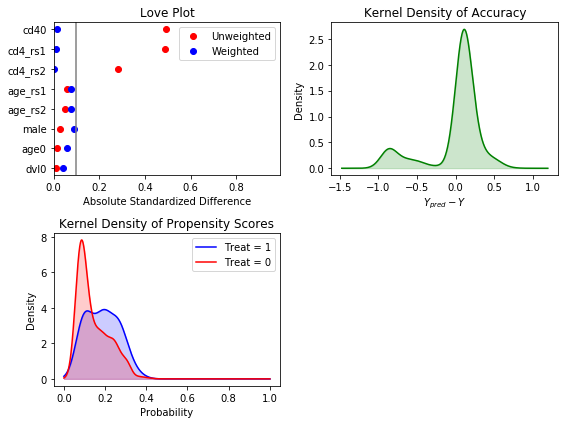

In [7]:
tml.run_diagnostics()

Both models appear to have adequate performance (there are no obvious problems).

## Tuning Parameters
Luckily in our example, we don't have an issue estimating the predicted probabilities of ART. This can possibly cause issues in the estimation procedure. One solution is to "trim" the estimated propensity scores. This is commonly used in propensity score and IPTW methods. By using the `bound` optional argument in the `exposure_model()` function, we can restrict the predicted probabilities. 

As demonstration, we will restrict to predicted probabilties of treatment between 0.01 to 0.99. Asymmetrical bounds can also be specified

In [8]:
tml = TMLE(dfcc, exposure='art', outcome='dead')
tml.exposure_model('male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0', bound=[0.01, 0.99], print_results=False)
tml.outcome_model('art + male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0', print_results=False)
tml.fit()
tml.summary()

                Targeted Maximum Likelihood Estimator                 
Treatment:        art             No. Observations:     517                 
Outcome:          dead            No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Q-Model:          Logistic       
Risk Difference:     -0.082
95.0% two-sided CI: (-0.154 , -0.009)
----------------------------------------------------------------------
Risk Ratio:          0.552
95.0% two-sided CI: (0.285 , 1.07)
----------------------------------------------------------------------
Odds Ratio:          0.502
95.0% two-sided CI: (0.239 , 1.054)


When restricting the probabilities in our example, similar results are obtained. Caution should be used when using this argument. This approach may "smooth" over important outliers or change the generalizability/transportability of your results. This should be considered as a last option if you have trouble estimating TMLE.

## Machine Learning
Previously we used the default statistical model of `TMLE`. One of the major advantages of `TMLE` is the ability to use machine learning models to estimate a causal effect. Methods like the g-formula can use machine learning to estimate point-estimates, but certain algorithms are invalid for bootstrapping. We are unable to obtain valid confidence intervals. TMLE, through efficient influence curves, allows us to obtain valid confidence intervals from machine learning algorithms without bootstrapping. 

I will demonstrate TMLE with super learner. Super learner is a generalized stacking algorith. Briefly, super learner allows us to specify a few different machine learning algorithm options. Based on cross-validated standard errors, the best performing machine learning algorithms are selected. An extensive discussion of how super learner works and how it is estimated is available here: [Rose 2013](https://academic.oup.com/aje/article/177/5/443/141300). The Python implementation of super learner I will use can be downloaded from [this GitHub repo](https://github.com/alexpkeil1/SuPyLearner). It is not currently available through PyPI.

To use machine learning models, we set up the models to be estimated (everything before `fit()` is called). Then we can estimate the algorithms by specifying `custom_model` in the corresponding model statments. Currently, `TMLE` supports `supylearner` and `sklearn` algorithms. If you have a library of machine learning algorithms you would like to see implemented, please let me know on GitHub and I can work on adding support.

For our example, we will use a neural network, L1-penalized logistic regression model, L2-penalized logistic regression model, random forest, AdaBoost, and Naive Bayes. These algorithms will be used for both the exposure and outcome models

In [9]:
import supylearner
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Initializing the ML algorithms
neural = MLPClassifier(hidden_layer_sizes=(8,), random_state=1463)
log1 = LogisticRegression(penalty='l1', random_state=201)
log2 = LogisticRegression(penalty='l2', random_state=103)
randf = RandomForestClassifier(random_state=141)
adaboost = AdaBoostClassifier(random_state=505)
bayes = GaussianNB()

# Initializing SuPyLearner with the above algorithms
lib = [neural, log1, log2, randf, adaboost, bayes]
libnames = ["Neural-Net", "Log_L1", "Log_L2", "Random Forest", "AdaBoost", "Bayes"]
sl = supylearner.SuperLearner(lib, libnames, loss="nloglik", K=10, print_results=False)

# Estimating TMLE with ML algorithms
tmle = TMLE(dfcc, exposure='art', outcome='dead')  # Step 1) Initialize TMLE class
tmle.exposure_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                    custom_model=sl, print_results=False)  # Step 2) Specify exposure model
tmle.outcome_model('art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                   custom_model=sl, print_results=False)  # Step 3) Specify outcome model
tmle.fit()  # Step 4) Targeting step

tmle.summary()

c:\users\zivic\python programs\development\zepid\zepid\causal\doublyrobust\TMLE.py:237: UserWarning: TMLE can result in confidence intervals below nominal coverage when used with machine learning algorithms. TMLE will no longer support custom machine learning models in v0.9.0
  warnings.warn("TMLE can result in confidence intervals below nominal coverage when used with "
c:\users\zivic\python programs\development\zepid\zepid\causal\doublyrobust\TMLE.py:387: UserWarning: TMLE can result in confidence intervals below nominal coverage when used with machine learning algorithms. TMLE will no longer support custom machine learning models in v0.9.0
  warnings.warn("TMLE can result in confidence intervals below nominal coverage when used with "


                Targeted Maximum Likelihood Estimator                 
Treatment:        art             No. Observations:     517                 
Outcome:          dead            No. Missing Outcome:  0                   
g-Model:          User-specified  Missing Model:        None                
Q-Model:          User-specified 
Risk Difference:     -0.081
95.0% two-sided CI: (-0.15 , -0.012)
----------------------------------------------------------------------
Risk Ratio:          0.555
95.0% two-sided CI: (0.297 , 1.038)
----------------------------------------------------------------------
Odds Ratio:          0.505
95.0% two-sided CI: (0.25 , 1.019)


The TMLE with super learner produces similar results. This suggests we did a decent job of specifying the functional form our parametric models. In the next tutorials, we will outline how to handle missing outcome data and continuous outcomes.

# Conclusion
In this tutorial, I have described TMLE and its usage in *zEpid*. In this tutorial, I have focused on a complete case analysis for a binary outcome with both parametric logistic regression models and machine learning algorithms. In the next tutorials, we will review how to use `TMLE` with missing outcome data and `TMLE` for continuous outcomes.

## References

Schuler, Megan S., and Sherri Rose. "Targeted maximum likelihood estimation for causal inference in observational studies." American Journal of Epidemiology 185.1 (2017): 65-73.

van der Laan, Mark J., and Sherri Rose. Targeted learning: causal inference for observational and experimental data. Springer Science & Business Media, 2011.

van Der Laan, Mark J., and Daniel Rubin. "Targeted maximum likelihood learning." The International Journal of Biostatistics 2.1 (2006).

Gruber, S., & van der Laan, M. J. (2011). tmle: An R package for targeted maximum likelihood estimation.